# Script para concatenar e corrigir dados do PurpleAir
Desenvolvido por Nicole Laureanti - nlaureanti@gmail.com

Bibliotecas utilizadas: pandas, matplotlib.pyplot e numpy

Tarefas: Concatenação de diferentes planilhas do PurpleAir e de arquivos de sensores offiline SD + Correção dos valores de pm2.5 considerando dois pontos distintos de medição para o mesmo horário + Conversão da temperatura para Celsius e do horário para hora local + Agrupamento e/ou média dos dados para diferentes tempos com a função resample + Plotagem gráfica + Geração de planilhas excel com as variáveis necessárias

Pré-execução: instalar bibliotecas em um ambiente conda

Ref:<https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html>


conda create --name PurpleAir python=3.8


conda activate PurpleAir

conda install -c conda-forge matplotlib

conda install -c conda-forge pandas

conda install -c conda-forge jupyter 

In [2]:
import pandas as pd    # conjunto de funções que se usa para dados em tabela (csv)
#https://pandas.pydata.org/docs/index.html
import matplotlib.pyplot as plt # conjunto de funções que se usa para plotagem 
#https://matplotlib.org/stable/index.html
import numpy as np

In [11]:
datai='20211010'
dataf='20211015'
sensor_offline=False # Se True usa arquivos do SD, Falso usa arquivos no site
estacaoA1='IFPR (outside) (-25.58615 -48.563952) Primary Real Time'
estacaoB1='IFPR B (undefined) (-25.58615 -48.563952) Primary Real Time'

estacaoA1='Reserva dos Papagaios (outside) (-25.223289 -48.454511) Primary Real Time'
estacaoB1='Reserva dos Papagaios B (undefined) (-25.223289 -48.454511) Primary Real Time'

nome_saida='teste.csv'
nome_figura='teste.png'
pasta_arq='./dados_mapacalor/'  # se os arquivos não estiverem na mesma pasta do script, indicar aqui a pasta
media_freq=False

# Lendo arquivos dos sensores

In [4]:
df_list_dates=[]
list_estacoes=[estacaoA1,estacaoB1]
dt=pd.date_range(start=pd.to_datetime(datai,format='%Y%m%d'),
                    end=pd.to_datetime(dataf,format='%Y%m%d'),
                    freq="D") #controla o nome dos arquivos/planilhas

if not sensor_offline: #dados online
    print("---"*10,"\nObtendo dados online")
    df_list_stat= []
    fnames2=[ estacao+ f' {dt[0].to_pydatetime().month:02d}_{dt[0].to_pydatetime().day:02d}_{dt[0].to_pydatetime().year} {dt[-1].to_pydatetime().month:02d}_{dt[-1].to_pydatetime().day+1:02d}_{dt[-1].to_pydatetime().year}.csv'
               for estacao in list_estacoes]
    for d in dt:
        if "Real Time" in estacaoA1:
            print("formato: Real time")
            fnames=[ estacao+ f' {d.to_pydatetime().month:02d}_{d.to_pydatetime().day:02d}_{d.to_pydatetime().year} {d.to_pydatetime().month:02d}_{d.to_pydatetime().day+1:02d}_{d.to_pydatetime().year}.csv'
               for estacao in list_estacoes]        
        else:
            print("[Warning!] dados acumulados em 1440 min? Talvez precise arrumar var:fnames")
            fnames=[ estacao+ f' {d.to_pydatetime().month:02d}_{d.to_pydatetime().day}_{d.to_pydatetime().year} {d.to_pydatetime().month:02d}_{d.to_pydatetime().day}_{d.to_pydatetime().year}.csv'
               for estacao in list_estacoes]
    for file in fnames[:]+fnames2[:]  :      
        try:
            df_list_stat.append(pd.read_csv(f'{pasta_arq}/{file}',
                     sep=',',header=0, index_col=0,
                       parse_dates=["created_at"], na_values='NaN'))
        except:
            print(f'\t[!] não foi possível ler: {pasta_arq}/{file} .ignorado.')
    if len(df_list_stat) == 0:
           print(f'\n[ERRO] nenhum arquivo lido, conferir \nlista de datas ({datai}-{dataf}) \npasta: {pasta_arq}')
    else:    
        print("---"*4,f"Transformando {d} de UTC->GMT(em minutos)")
        for f in range(len(df_list_stat)):
            #print(f'antes {list_estacoes[f]} \n\t->',len(df_list_stat[f].index),df_list_stat[f].index[0],df_list_stat[f].index[-1])
            df_list_stat[f].index = pd.to_datetime(df_list_stat[f].index, unit='m').tz_convert('America/Sao_Paulo')
            if media_freq: 
                df_list_stat[f]=df_list_stat[f].resample('1D').mean() #fazer a soma por minuto ?
            #print(f'depois {list_estacoes[f]} \n\t->',len(df_list_stat[f].index),df_list_stat[f].index[0],df_list_stat[f].index[-1])

        df_list_dates.append(pd.concat(df_list_stat, keys=['A', 'B'],
                  names=['Estacao',"dates"],axis=0)) 
        df=pd.concat(df_list_dates,axis=0)
        print(f"Removendo datas diferentes de A e B")
        ac=0
        for d in df.loc[('A')].index.difference(df.loc[('B')].index):
            ac=ac+1
            df.drop(index=('A',d))
        print(f'Dropped: {ac} data (in A but not in B')
        print("ok.")
        
if sensor_offline: #dados offline
    print("---"*10,"\nObtendo dados offline")
    df_list_dates=[]
    fnames=[ f"{d.to_pydatetime().year}{d.to_pydatetime().month:02d}{d.to_pydatetime().day}.csv" for d in dt ]
    for file in fnames:
        try:
            df_list_dates.append(pd.read_csv(f'{pasta_arq}/{file}',
                        sep=',',header=0, index_col=0,    #usecols=['UTCDateTime','current_temp_f'] #para especificar as únicas colunas a serem lidas
                        parse_dates=["UTCDateTime"], na_values='NaN') )
        except:
            print(f'\t[!] não foi possível ler: {pasta_arq}/{file} .ignorado.')    

    
    df=pd.concat(df_list_dates,axis=0)
    print(f"Transformando de UTC->GMT(em minutos)")
    #print('antes',df.index)
    df.index=pd.to_datetime(df.index,unit='m').tz_convert('America/Sao_Paulo')
    if media_freq: 
        df=df.resample('1H').mean() #fazer a média por minuto ?
    #print('depois',df.index)              
    print("ok.")

------------------------------ 
Obtendo dados online
formato: Real time
formato: Real time
formato: Real time
formato: Real time
formato: Real time
formato: Real time
	[!] não foi possível ler: ./dados_mapacalor//Reserva dos Papagaios (outside) (-25.223289 -48.454511) Primary Real Time 10_15_2021 10_16_2021.csv .ignorado.
	[!] não foi possível ler: ./dados_mapacalor//Reserva dos Papagaios B (undefined) (-25.223289 -48.454511) Primary Real Time 10_15_2021 10_16_2021.csv .ignorado.
------------ Transformando 2021-10-15 00:00:00 de UTC->GMT(em minutos)
Removendo datas diferentes de A e B
Dropped: 2402 data (in A but not in B
ok.


In [5]:
print(df)


                                   entry_id  PM1.0_CF1_ug/m3  PM2.5_CF1_ug/m3  \
Estacao dates                                                                   
A       2021-10-10 08:28:50-03:00     21185             0.00             0.00   
        2021-10-10 08:32:50-03:00     21186             0.00             0.00   
        2021-10-10 08:54:50-03:00     21187             0.00             0.00   
        2021-10-10 09:16:49-03:00     21188             0.00             0.00   
        2021-10-10 09:18:49-03:00     21189             0.00             0.00   
...                                     ...              ...              ...   
B       2021-10-16 16:02:45-03:00     23584             3.00             4.64   
        2021-10-16 16:04:44-03:00     23585             3.07             4.90   
        2021-10-16 16:06:45-03:00     23586             2.78             5.50   
        2021-10-16 16:08:44-03:00     23587             3.63             5.81   
        2021-10-16 16:10:44-

Limpando as colunas indesejadas

In [6]:
if sensor_offline:
    try:
        df=df.drop(columns=['mac_address','firmware_ver','hardware'])
    except:
        print("Colunas removidas: 'mac_address' 'firmware_ver' 'hardware'")

else:
    try:
        df=df.drop(columns=['entry_id'])
    except:
        print("Colunas removidas: 'entry_id'")
      

# Aplicando correção

In [7]:
if sensor_offline:
    
        print(f"Colunas input: {df.columns}")
        print("> Fazendo a correção de pm2.5")
        df['pm2.5']= (df['pm2_5_cf_1']+df['p_2_5_um_b'])*0.524/2-0.0862*df['current_humidity']+5.75
        df_dy=df.resample('1D').mean()
        print('----'*24)

        #print(f"24h mean A: {df_dy['pm2_5_cf_1'].values} B: {df_dy['p_2_5_um_b'].values}", f" dif: {df_dy['pm2_5_cf_1']-df_dy['p_2_5_um_b'].values}")
        
        print("\n\n> Excluindo valores (Critério 1: 90% dados completos)")  
        print(df['pm2_5_cf_1'].resample('1D').count() < .90*24*30)
        df['criterio1']= [ df['pm2_5_cf_1'].resample('1D').count().loc[d.strftime("%D")]  < .90*24*30 for d in pd.to_datetime(df_saida.index, unit='D') ]
        print(f"Se {df['pm2_5_cf_1'].resample('1D').count().values} < {.90*24*30} :: {df['pm2_5_cf_1'].resample('1D').count().values < .90*24*30}")
        
        print("\n\n> Excluindo valores (Critério 2: Equação % diff em 24h > .61) Barkjohn et al. (2021)")
        criterio2 = ( abs(df_dy['pm2_5_cf_1']-df_dy['p_2_5_um_b']) *2 ) / (df_dy['pm2_5_cf_1']+df_dy['p_2_5_um_b'])
        print(f"Se {criterio2.values} > .61 ::: exclui? {criterio2.values > .61} \n")
        print(criterio2 > .61)
        df['criterio2'] = [ criterio2.loc[d.strftime("%D")] > .61 for d in pd.to_datetime(df.index, unit='D') ]
        
        criterio3=abs((df['pm2_5_cf_1'].resample('1D').mean()-df['p_2_5_um_b'].resample('1D').mean())) > .55*df['pm2_5_cf_1'].resample('1D').mean().values
        print("\n\n> Excluindo valores (Critério 3: Diff SomaDiária) Tryner et al. (2020)")     
        print(f"Se {abs((df['pm2_5_cf_1'].resample('1D').mean()-df['p_2_5_um_b'].resample('1D').mean()).values)} > {.55*df['pm2_5_cf_1'].resample('1D').mean().values} ::: exclui? "\
              f"{(abs((df['pm2_5_cf_1'].resample('1D').mean()-df['p_2_5_um_b'].resample('1D').mean())) > .55*df['pm2_5_cf_1'].resample('1D').mean()).values} ")
        df['criterio3'] = [ criterio3.loc[d.strftime("%D")] for d in pd.to_datetime(df.index, unit='D') ]
        print(abs((df['pm2_5_cf_1'].resample('1D').mean()-df['p_2_5_um_b'].resample('1D').mean())) > .55*df['pm2_5_cf_1'].resample('1D').mean().values)

        print('----'*24)
        print("> Fazendo a correção de temperatura")
        df['current_temp_c']= (df['current_temp_f']-32)*5/8
        print("> Salvando no DataFrame de saída")
        df_saida=pd.DataFrame(columns=['pm2.5A','pm2.5B','pm2.5','Temperature_C',"UR",
                                      "criterio1", "criterio2", "criterio3"],
                             index=pd.to_datetime(df.index))
        df_saida['pm2.5A']=df['pm2_5_cf_1']; df_saida['pm2.5B']=df['p_2_5_um_b']; df_saida['pm2.5']=df['pm2.5']
        df_saida['criterio1']=df['criterio1'].replace(np.nan,'');df_saida['criterio2']=df['criterio2'].replace(np.nan,'');df_saida['criterio3']=df['criterio3'].replace(np.nan,'')
        df_saida['Temperature_C']=df['current_temp_c']
        df_saida['UR']=df['current_humidity']
        print(f"Saída: {df_saida}")
        print(f"""\tPara conferir:\n\tpm25A: {df_saida['pm2.5A'][-1]}, pm25B {df_saida['pm2.5B'][-1]},
             pm25final {(df_saida['pm2.5A'][-1]+df_saida['pm2.5B'][-1])*0.524/2-0.0862*df['current_humidity'][-1]+5.75} == {df_saida['pm2.5'][-1]}\n
    \tTempC: {df_saida['Temperature_C'][-1]} TempF: {df['current_temp_f'][-1]}""")
         

In [8]:
if not sensor_offline: #apenas correção
    print([f"Arquivo input: {list_estacoes[n]}" for n in range(len(list_estacoes))],
         f"\nColunas input: {df.columns}")
    if df.loc[('A')].index[0] != df.loc[('B')].index[0]: print(f"[Warning!] 1st day-A: {df.loc[('A')].index[0]} 1st day-B: {df.loc[('B')].index[0]}")
    df_saida=pd.DataFrame(columns=['pm2.5A','pm2.5B','pm2.5','Temperature_C',"UR",'criterio1','criterio2','criterio3'],
                             index=pd.to_datetime(df.loc[('A')].index))
    print("> Correção de pm2.5 e temperatura F->C")
    
    for d in range(len(df.loc[('A')].index)):
        try:
            pm25A=df.loc[('A'),'PM2.5_CF1_ug/m3'].iloc[d]
            pm25B=df.loc[('B'),'PM2.5_CF1_ug/m3'].iloc[d]
            ur=df.loc[('A'),'Humidity_%'].iloc[d]
            df_saida.iloc[d].loc['pm2.5A']=pm25A
            df_saida.iloc[d].loc['pm2.5B']=pm25B
            df_saida.iloc[d].loc['UR']=ur
        
            df_saida.iloc[d].loc['pm2.5'] = (pm25A+pm25B)*0.524/2 - 0.0862*ur+5.75
            df_saida.iloc[d].loc['Temperature_C']= (df.loc[('A'),'Temperature_F'][d]-32)*5/8
        except:
            print(f'skip day {d}')
    print('----'*24)        
    print("> Calculando critérios")
    print("\n\n> Excluindo valores (Critério 1: 90% dados completos)")
    
    df_saida['criterio1']=df_saida['pm2.5'].where(df_saida['pm2.5A'].resample('1D').count() < .90*24*30, other='False')
    print(f"Se {df_saida['pm2.5A'].resample('1D').count().values} < {.90*24*30} :: {df_saida['pm2.5A'].resample('1D').count().values < .90*24*30}")
    print(df_saida['pm2.5A'].resample('1D').count() < .90*24*30)
    df_saida['criterio1'] = [ df_saida['pm2.5A'].resample('1D').count().loc[d.strftime("%D")]  < .90*24*30 for d in pd.to_datetime(df_saida.index, unit='D') ]
    
    print("\n\n> Excluindo valores (Critério 2: Equação % diff em 24h > .61) Barkjohn et al. (2021)")       
    criterio2 = 2*(abs(df_saida['pm2.5A'].resample('1D').mean()-df_saida['pm2.5B'].resample('1D').mean()) ) / (df_saida['pm2.5A'].resample('1D').mean()+df_saida['pm2.5B'].resample('1D').mean())
    print(f"Se {criterio2.values} > .61 ::: exclui? {criterio2.values > .61} \n")       
    df_saida['criterio2'] = [ criterio2.loc[d.strftime("%D")] > .61 for d in pd.to_datetime(df_saida.index, unit='D') ]
    print(criterio2 > .61)
    
    print("\n\n> Excluindo valores (Critério 3: Diff SomaDiária) Tryner et al. (2020)")     
    criterio3=abs( df_saida['pm2.5A'].resample('1D').mean()-df_saida['pm2.5B'].resample('1D').mean() )  > .55*df_saida['pm2.5A'].resample('1D').mean().values
    df_saida['criterio3']=[ criterio3.loc[d.strftime("%D")] for d in pd.to_datetime(df_saida.index, unit='D') ]
    print(f"Se {abs((df_saida['pm2.5A'].resample('1D').mean()-df_saida['pm2.5B'].resample('1D').mean()).values)} > {.55*df_saida['pm2.5A'].resample('1D').mean().values} ::: exclui? "\
              f"{abs((df_saida['pm2.5A'].resample('1D').mean()-df_saida['pm2.5B'].resample('1D').mean()).values) > .55*df_saida['pm2.5A'].resample('1D').mean().values}")
    print(abs( df_saida['pm2.5A'].resample('1D').mean()-df_saida['pm2.5B'].resample('1D').mean() )  > .55*df_saida['pm2.5A'].resample('1D').mean().values)
    print(f"Saída: {df_saida.replace(np.nan,'')}")
    print(f"""\tPara conferir:\n\tpm25A: {pm25A}, pm25B {pm25B}, pm25final {df_saida.iloc[d-1].loc['pm2.5']}\n
    \tTempC: {df_saida['Temperature_C'].iloc[d-1]} TempF: {df.loc[('A'),'Temperature_F'].iloc[d-1]}""")


['Arquivo input: Reserva dos Papagaios (outside) (-25.223289 -48.454511) Primary Real Time', 'Arquivo input: Reserva dos Papagaios B (undefined) (-25.223289 -48.454511) Primary Real Time'] 
Colunas input: Index(['PM1.0_CF1_ug/m3', 'PM2.5_CF1_ug/m3', 'PM10.0_CF1_ug/m3',
       'UptimeMinutes', 'RSSI_dbm', 'Temperature_F', 'Humidity_%',
       'PM2.5_ATM_ug/m3', 'Unnamed: 10', 'ADC', 'Pressure_hpa', 'IAQ'],
      dtype='object')
[Warning!] 1st day-A: 2021-10-10 08:28:50-03:00 1st day-B: 2021-10-10 08:32:56-03:00
> Correção de pm2.5 e temperatura F->C
------------------------------------------------------------------------------------------------
> Calculando critérios


> Excluindo valores (Critério 1: 90% dados completos)
Se [193 270 482 715 496 159  87] < 648.0 :: [ True  True  True False  True  True  True]
dates
2021-10-10 00:00:00-03:00     True
2021-10-11 00:00:00-03:00     True
2021-10-12 00:00:00-03:00     True
2021-10-13 00:00:00-03:00    False
2021-10-14 00:00:00-03:00     True


# Plotagem

Plotagem
> Usando resample para DatetimeIndexResampler [freq=<30 * Minutes>, axis=0, closed=left, label=right, convention=start, origin=start_day]
dates
2021-10-10 08:30:00-03:00    -1.0598
2021-10-10 09:00:00-03:00    -2.1196
2021-10-10 09:30:00-03:00    -6.8152
2021-10-10 10:00:00-03:00    -7.1854
2021-10-10 10:30:00-03:00    -10.872
                              ...   
2021-10-16 14:30:00-03:00    2.04308
2021-10-16 15:00:00-03:00     1.7947
2021-10-16 15:30:00-03:00    3.16654
2021-10-16 16:00:00-03:00      2.085
2021-10-16 16:30:00-03:00    14.0964
Freq: 30T, Name: pm2.5, Length: 305, dtype: object


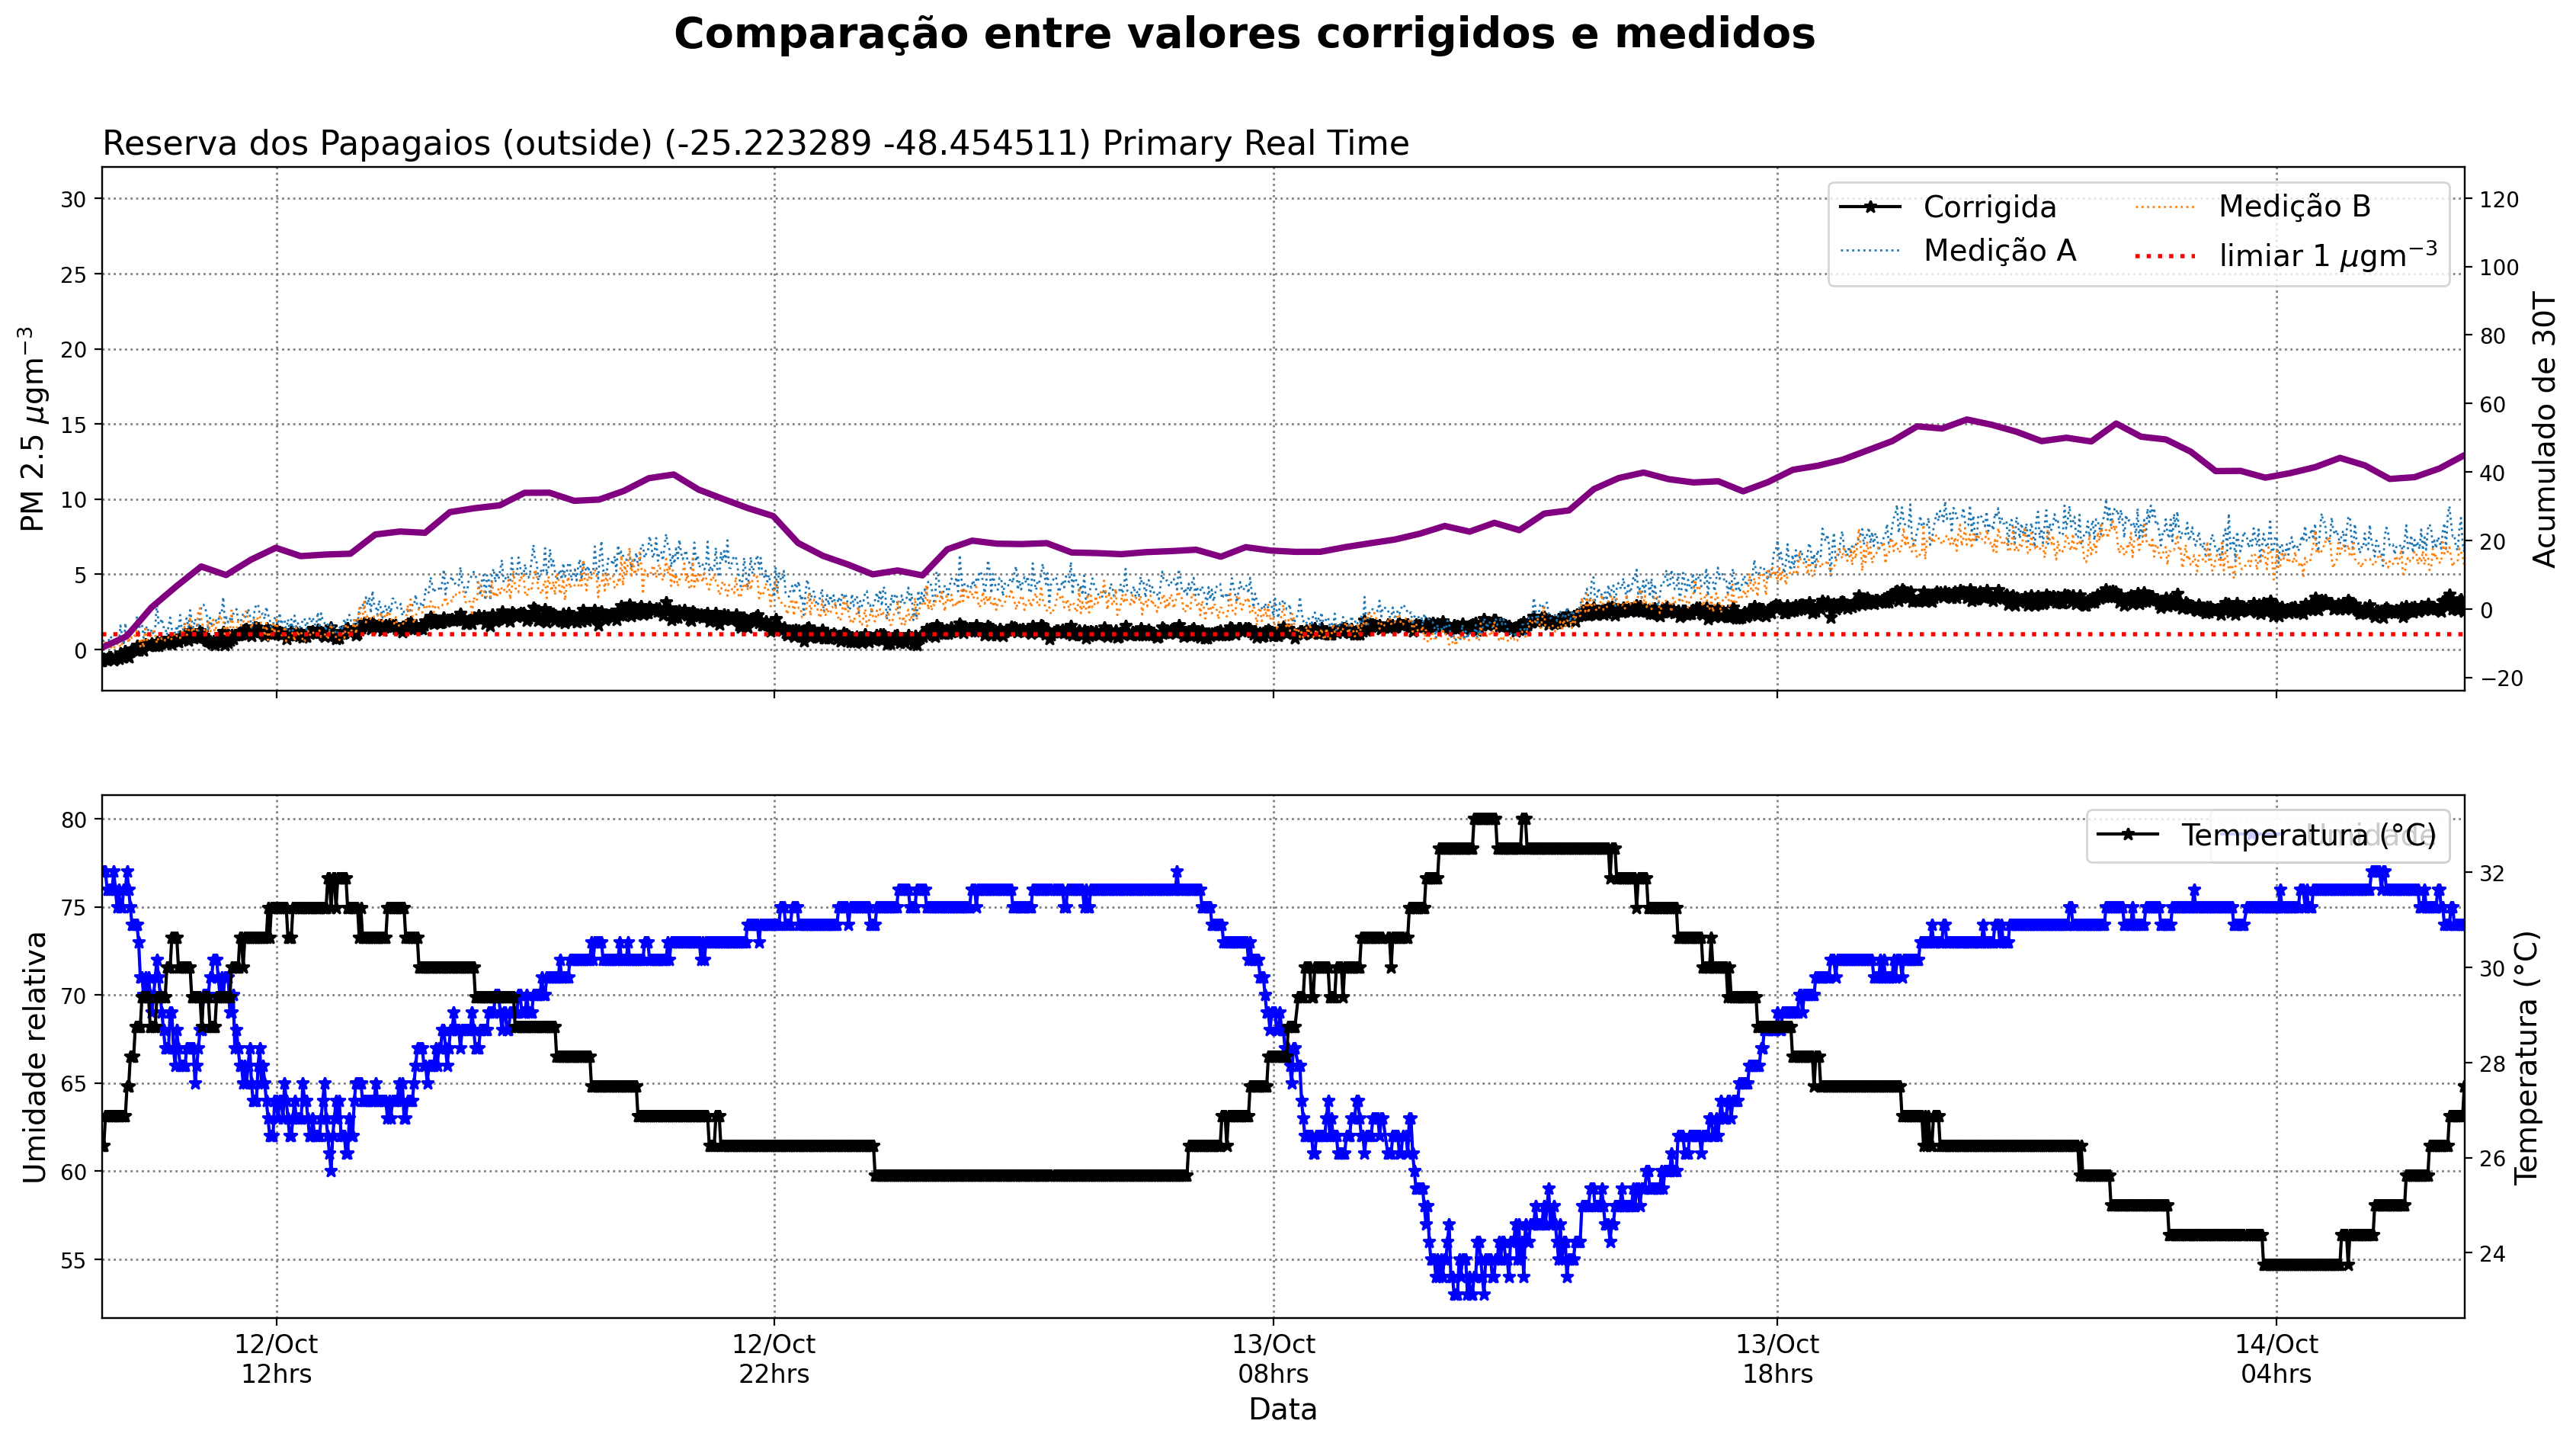

In [19]:
############################################################################################
dt_grph=300                    #variação temporal do eixo x do gráfico
dt_format='%d/%b\n%Hhrs'      #Formato de saida temporal do gráfico
valor_resample='30T'
limiar=1  #linha tracejada
nome_estacao=f"{list_estacoes[0]}"
############################################################################################
print("Plotagem")    
    
fig, ax = plt.subplots(2,figsize=(20,10),dpi=200,sharex=True) 

###########Plot de pm2.5
ax[0].plot(df_saida.index,df_saida['pm2.5'],label="Corrigida",marker='*',color='black')
ax[0].plot(df_saida.index,df_saida['pm2.5A'],label=f"Medição A", linestyle=':', #marker='o',
                linewidth=1)
ax[0].plot(df_saida.index,df_saida['pm2.5B'],label=f"Medição B", linestyle=':', #marker='o',
                linewidth=1)
ax[0].axhline(limiar,label=f'limiar {limiar}'+' $\mu$gm$^{-3}$',linestyle=':',linewidth=2,color='red') #linha tracejada
ax[0].set_xticks(df_saida.index[::dt_grph])
plt.xlim(df_saida.index[700],df_saida.index[2400])

ax2=ax[0].twinx() #cria novo eixo y dentro do mesmo gráfico
med=df_saida.resample(valor_resample, label='right')['pm2.5'].sum()
print(f"> Usando resample para {df_saida.resample(valor_resample, label='right')}")
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
df_saida[f'pm2.5 {valor_resample}']=med
print(med)
ax2.plot(med,label=f"Acumulado de {valor_resample}", linewidth=3,color='purple')
ax2.set_ylabel(f"Acumulado de {valor_resample}",fontsize=14)

ax[0].set_ylabel('PM 2.5 $\mu$gm$^{-3}$',fontsize=14)
ax[0].grid(color='gray',linestyle=':',linewidth=1)
ax[0].set_title(nome_estacao,loc='left',fontsize=16)
ax[0].legend(fontsize=14,ncol=2)
ax[0].set_ylim=([0,16])


###########Plot de Temperatura e umidade
ax[1].plot(df_saida.index,df_saida['UR'],label="Umidade",marker='*',color='blue')
ax[1].legend(fontsize=14)
ax[1].set_ylabel('Umidade relativa',fontsize=14)
    
ax2=ax[1].twinx() #cria novo eixo y dentro do mesmo gráfico
ax2.plot(df_saida.index,df_saida['Temperature_C'],label="Temperatura (°C)",marker='*',color='black')
ax2.set_ylabel("Temperatura (°C)",fontsize=14)
ax2.legend(fontsize=14)


xticklbls = pd.to_datetime(df_saida.index).strftime(dt_format)
ax[1].set_xticks(df_saida.index[::dt_grph])
ax[1].set_xticklabels(xticklbls[::dt_grph], rotation=0,fontsize=12) 
ax[1].set_xlabel('Data',fontsize=14)
ax[1].grid(color='gray',linestyle=':',linewidth=1)


plt.suptitle(f"Comparação entre valores corrigidos e medidos",fontweight='bold',fontsize=20)
plt.savefig(nome_figura,facecolor='white')

#Para fazer a figura com o recorte
plt.xlim([pd.to_datetime('2021-10-12 12:00:00'),pd.to_datetime('2021-10-14 08:30:00-03:00')])
plt.savefig('cut1_'+nome_figura,facecolor='white')

# Salvando outputs no formato csv

In [9]:
print(df_saida.replace(np.nan,''))

try:
    len(nome_saida)
except:        
    datai=dt[0]
    dataf=dt[-1]
    nome_saida= estacaoA1 + f' {datai.to_pydatetime().month:02d}_{datai.to_pydatetime().day:02d}_{datai.to_pydatetime().year} {dataf.to_pydatetime().month:02d}_{dataf.to_pydatetime().day+1:02d}_{dataf.to_pydatetime().year}-corrigido.csv'
print(f" Salvando DataFrame de saída em {nome_saida}")    
df_saida.replace(np.nan,'').to_csv(nome_saida,sep=',',decimal='.') #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html

                           pm2.5A  pm2.5B    pm2.5  Temperature_C    UR  \
dates                                                                     
2021-10-10 08:28:50-03:00    0.00    0.00 -1.05980         23.125  79.0   
2021-10-10 08:32:50-03:00    0.00    0.00 -1.05980         23.125  79.0   
2021-10-10 08:54:50-03:00    0.00    0.00 -1.05980         23.750  79.0   
2021-10-10 09:16:49-03:00    0.00    0.00 -0.97360         23.750  78.0   
2021-10-10 09:18:49-03:00    0.00    0.00 -0.97360         23.750  78.0   
...                           ...     ...      ...            ...   ...   
2021-10-16 16:02:38-03:00    6.53    3.36  2.04858         26.250  73.0   
2021-10-16 16:04:38-03:00    7.67    5.36  2.87126         26.250  73.0   
2021-10-16 16:06:39-03:00    5.62    4.64  2.14552         26.250  73.0   
2021-10-16 16:08:38-03:00    6.92    4.90  2.64044         26.250  72.0   
2021-10-16 16:10:38-03:00    6.27    5.50  2.54114         26.250  73.0   

                        